In [181]:
""" import useful functions """

# Generic
import pandas as pd
import numpy as np
import scipy
import sys

# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# MCMC methods
import emcee

# cosmology
import pyccl as ccl

%matplotlib inline

In [182]:
## EXAMPLE1: example of how to import power spectrum

"""
# import data P(k) and k for some simulation

with open('/home/c2042999/C_EEl_project/C_EEl_data/Test_sim.dat',"r") as data:
    d = np.loadtxt(data)
    d = np.transpose(d)
    z = d[0]
    k = d[1]
    Pk = d[2]

plt.plot(k[:288],Pk[:288])
plt.xscale('log')
plt.yscale('log')

del d, z, k, Pk
"""

'\n# import data P(k) and k for some simulation\n\nwith open(\'/home/c2042999/C_EEl_project/C_EEl_data/Test_sim.dat\',"r") as data:\n    d = np.loadtxt(data)\n    d = np.transpose(d)\n    z = d[0]\n    k = d[1]\n    Pk = d[2]\n\nplt.plot(k[:288],Pk[:288])\nplt.xscale(\'log\')\nplt.yscale(\'log\')\n\ndel d, z, k, Pk\n'

z is np.linspace(0.001 , 5.0 , int(1e4))

## Find binned redshift distribution (define z and output Binned_distribution(z))

In [183]:
""" Get a binned redshift distribution - defining functions """

# define the reasonable redshift distribution (not normalized yet)

def redshiftdist(z):
    
    alpha = 1.27
    beta = 1.02
    z0 = 0.5
    pz = z**alpha * np.exp(-(z / z0)**beta)                                # Redshift distribution, p(z)
    return pz

# complete binning of z so that integral of redshiftdist(z) between bins stays the same. Need redshiftdist(z) to be Normalized
# (in limit of large z linspace)

def bindist(z, n_bins):
                                                                          # have redshiftdist(z), z 
                                                                          # find bins: integrate between 0 and i redshift(z)
                                                                          #            if integral => 1/n_bin, that is a bin
                                                                          #            repeat for 2/n_bin, 3/n_bin, etc
    pz = redshiftdist(z)
    N = scipy.integrate.simps(pz, z)                                      # Normalization factor
    pz = pz/N
    j = 1
    bins = np.zeros(int(n_bins + 1))
    for i in range(len(z) - 10):
        I = scipy.integrate.simps(pz[0 : i + 10], z[0 : i + 10])
        if I >= j / n_bins:
            bins[j] = z[i + 10]
            j += 1
    bins[int(n_bins)] = z[len(z) - 1]
    bins[0] = z[0]
    return bins

# define gaussian photo-z uncertainties

def gaussianphotoz(zs , zp):
    I = np.exp(-np.power(zs - zp , 2.) / (2 * np.power(0.05 * (1 + zp) , 2.)))
    N = scipy.integrate.simps(I , zs)
    return I/(N)

# bins distribution for redshiftdist(z) in n_bins with same number of galaxies in each bin, smoothened by gaussianphotoz(zs , zp) kernel

def binning_redshiftdist(z , n_bins):
    
    N = scipy.integrate.simps(redshiftdist(z), z)

    # complete binning
    bin_edges = bindist(z, n_bins)

    # smoothing redshift distribution with gaussian kernel

    Sum = 0                                                                       # find what the sum of normalized plots is. Want this equal to Rdist
    binned_redshiftdist = np.zeros((len(bin_edges) - 1, len(z)))

    for i in range(len(bin_edges) - 1):
        Rdist_new = np.zeros(len(z))
        conv = np.zeros(len(z))

        for j in range(len(z)):                                                  # define binned redshift functions before smoothing
            if z[j] >= bin_edges[i] and z[j] <= bin_edges[i+1]:
                Rdist_new[j] = redshiftdist(z[j])/(N)
    
        for j in range(len(z)):                                                  # smoothen distributions by convolving with a gaussian kernel
            conv[j] = scipy.integrate.simps(Rdist_new * gaussianphotoz(z , z[j]) , z)
    
        binned_redshiftdist[i] = conv
    
        Sum += conv
    
    #plt.plot(zp, conv)
    return binned_redshiftdist , Sum

In [184]:
""" Get a binned redshift distribution - getting the actual distribution """

# find normalized redshift distribution

z = np.linspace(0.001 , 5.0 , int(1e4))

Rdist = redshiftdist(z)
N = scipy.integrate.simps(Rdist, z)                                    # Normalization factor
Rdist = Rdist/N

Binned_distribution = binning_redshiftdist(z , 10)[0]

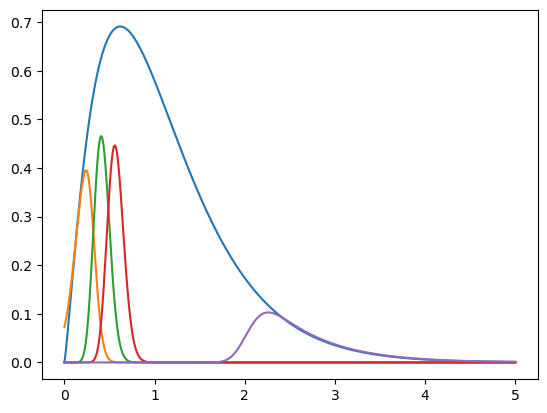

In [185]:
## TEST2: Plots to check binned redshift distribution


plt.plot(z , Rdist)
plt.plot(z ,Binned_distribution[0])
plt.plot(z ,Binned_distribution[1])
plt.plot(z ,Binned_distribution[2])
plt.plot(z ,Binned_distribution[9])


## Finding C_ell

In [211]:
""" Finding C_ell_array (our training data) - defining function """

def findC_ell_array(ell_min, ell_max, ell_bin_num, cosmo, cosmo_MCMC, z, Binned_distribution):
    
    #find ell arrays and empty arrays
    
    ell = np.arange(ell_min, ell_max)
        
    C_ell_array = []
    
    # define quantities for binning C_ell
    
    ell_binned_limits = np.logspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = (bin_edge1 + bin_edge2) / 2
    
    longell = []
    for i in range(int(len(cosmo)*((len(Binned_distribution) + 1) * len(Binned_distribution) / 2))):
        longell = np.append(longell, ell_binned)

    # find C_ell for a range of ells, then bin these to find C_ell_array 

    #Note: this gives list of C_ell[i][j][k][ell]: ith cosmology, cross correlated over jth and kth binned redshift 
    #      distribution for each binned value of ell. 

    for i in range(len(cosmo)):
        def pk_func(k, a):
            pk_nl = ccl.nonlin_matter_power(cosmo[i], k, a)
            pk_lin = ccl.linear_matter_power(cosmo[i], k, a)
            pk_fid = ccl.linear_matter_power(cosmo_MCMC, k, a)
            P_delta = (pk_nl/pk_lin) * pk_fid
            return P_delta
        
        P_delta2D = ccl.pk2d.Pk2D(cosmo=cosmo_MCMC, pkfunc=pk_func, lk_arr=np.logspace(-1,3,int(1e3)), a_arr=1/(1+z), is_logp=False)
        
        for j in range(len(Binned_distribution)):
            for k in range(len(Binned_distribution)):
                if k > j:
                    break
                tracer1 = ccl.WeakLensingTracer(cosmo[i], dndz=(z, Binned_distribution[j]))        # TODO normalization
                tracer2 = ccl.WeakLensingTracer(cosmo[i], dndz=(z, Binned_distribution[k]))
                C_ell = ccl.angular_cl(cosmo[i], tracer1, tracer2, ell, p_of_k_a=P_delta2D)        # uses non-linear matter power spectrum stored in `cosmo`

                # bin ell
                bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(ell, C_ell, statistic='mean', 
                                                                               bins= ell_binned_limits)
    
                C_ell_array = np.append(C_ell_array, bin_means)
    return longell, C_ell_array

In [212]:
""" define cosmological parameters """


c = 3e5                                                                  # km/s

cosmo_MCMC = ccl.Cosmology(Omega_c = 0.23, 
                      Omega_b = 0.045, 
                      h = 0.67, 
                      n_s = 0.65,
                      sigma8 = 0.65, 
                      transfer_function='bbks',
                      matter_power_spectrum='linear')

cosmo = np.zeros((3,3) , dtype=object)

for i in range(len(cosmo)):
    for j in range(len(cosmo[0])):
        cosmo[i][j] = ccl.Cosmology(Omega_c = 0.24, # + (0.04 * i), 
                      Omega_b = 0.045, 
                      h = 0.67, 
                      n_s = 0.7 + (0.15 * i),
                      sigma8 = 0.7 + 0.25 * j, 
                      transfer_function='bbks')
cosmo = np.append(np.append(cosmo[0] , cosmo[1]) , cosmo[2])

In [213]:
""" Create training data: find P_del for a set of 9 power spectra with different cosmologies """

""" -- NOTES on C_ell --
# redshift distribution is Binned_distribution from above.
# binned over 10 redshift distributions. That means that C_ell[i][j][k] is the C_ell for the ith cosmology, cross correlated over
# jth and kth redshift distribution, as a function of ell."""

# define ell and C_ell shapes 

ell_min = 2
ell_max = 2060

# define quantities for binning of ell

ell_bin_num = 18

# find C_ell for non-linear matter power spectrum

C_ell_data = findC_ell_array(ell_min, ell_max, ell_bin_num, cosmo, cosmo_MCMC, z, Binned_distribution)

longell = C_ell_data[0]
C_ell_array = C_ell_data[1]

del C_ell_data

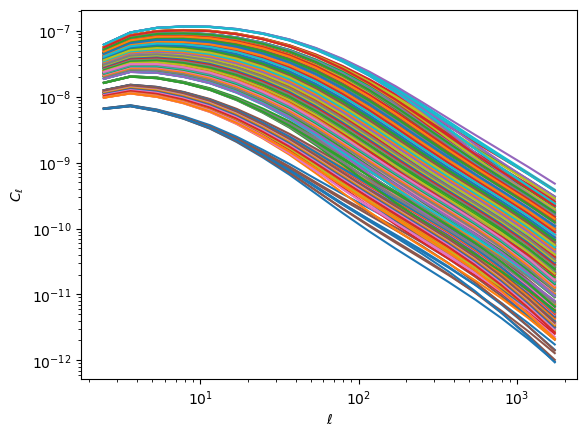

In [220]:
## TEST3: Plot C_ell to see if shapes are reasonable


for i in range(int(len(C_ell_array)/18 - 1)):
    plt.plot(longell[int(i*18):int((i+1)*18)], C_ell_array[int(i*18):int((i+1)*18)])


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()


# comment: sigma8 changes the y intercept (as sigma8 increases the value of y-intercept increases
#          OmegaM changes the power spectrum behaviour at high P (as OmegaM increases Cl increases at high l)

In [215]:
"""put C_ell data in right format"""

ell = longell[0:990]
B_data = np.zeros((len(cosmo), len(ell)))
for i in range(len(cosmo)):
    B_data[i] = C_ell_array[int(i*55*18):int((i+1)*55*18)]
    
    """plt.plot(ell[0:18],B_data[i][0:18])

plt.xscale("log")"""

In [216]:
""" Finding C_ell_array linear at each MCMC step - defining function """

def findC_ell_array_linear(ell_min, ell_max, ell_bin_num, cosmoMCMC, z, Binned_distribution):
    
    #find ell arrays and empty arrays
    
    ell = np.arange(ell_min, ell_max)
        
    C_ell_array = []
    
    # define quantities for binning C_ell

    ell_binned_limits = np.logspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = (bin_edge1 + bin_edge2) / 2
    
    # find C_ell for a range of ells, then bin these to find C_ell_array 

    for j in range(len(Binned_distribution)):
        for k in range(len(Binned_distribution)):
            if k > j:
                break
            tracer1 = ccl.WeakLensingTracer(cosmo_MCMC, dndz=(z, Binned_distribution[j])) # TODO normalization
            tracer2 = ccl.WeakLensingTracer(cosmo_MCMC, dndz=(z, Binned_distribution[k]))
            C_ell = ccl.angular_cl(cosmo_MCMC, tracer1, tracer2, ell)               # uses non-linear matter power spectrum stored in `cosmo`
            
            # bin ell
            bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(ell, C_ell, statistic='mean', 
                                                                           bins= ell_binned_limits)
    
            C_ell_array = np.append(C_ell_array, bin_means)
    return C_ell_array

In [217]:
"""Find C_ell with linear matter power spectrum"""

# ell and C_ell shapes, binning taken from above to be ell_min = 2, ell_max = 2060, ell_bin_num = 18

# find C_ell

M_data = findC_ell_array_linear(ell_min, ell_max, ell_bin_num, cosmo_MCMC, z, Binned_distribution)




Text(0, 0.5, '$\\frac{C^{00}_{NL}(\\ell)}{C^{00}_{Linear}(\\ell)} - 1$')

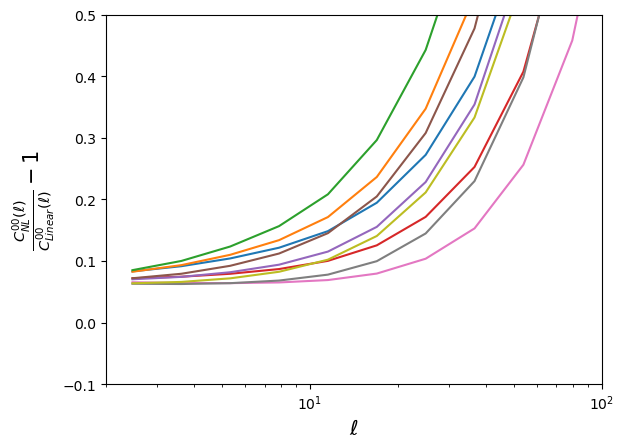

In [218]:
# TEST5: Plot processed data to compare with Huang et al 2020

frac = (B_data / M_data) - 1

plt.xscale('log')
plt.ylim(-0.1,0.5)
plt.xlim(2,1e2)
for i in range(len(cosmo)):
    plt.plot(ell[0:18],frac[i][0:18])

plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$\frac{C^{00}_{NL}(\ell)}{C^{00}_{Linear}(\ell)} - 1$', size = 15)

Text(0.5, 1.0, 'Cosmology: $\\sigma_8$ = 0.7 + 0.25$j$, $n_s$ = 0.7 + 0.15$i$ \n $\\ell_{min}$ = 2, $\\ell_{max}$ = 2060')

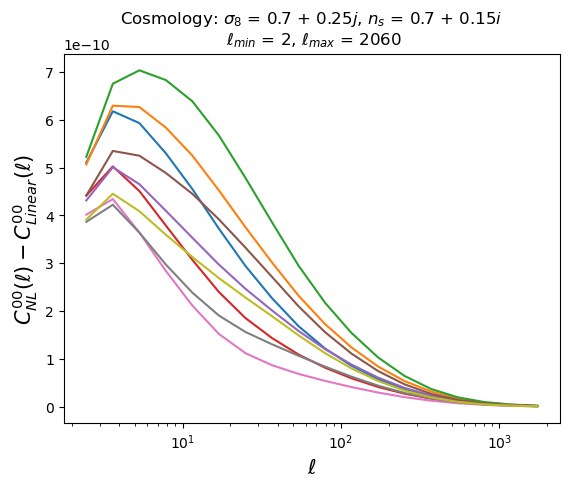

In [204]:
# TEST5: Plot processed data to compare with Huang et al 2020

sub = (B_data - M_data) 

plt.xscale('log')
#plt.ylim(0,0.5)
for i in range(len(cosmo)):
    plt.plot(ell[0:18],sub[i][0:18])
    
plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$C^{00}_{NL}(\ell) - C^{00}_{Linear}(\ell)$', size = 15)
plt.title("Cosmology: $\sigma_8$ = %1.1f + %1.2f$j$, $n_s$ = %1.1f + %1.2f$i$ \n $\ell_{min}$ = %i, $\ell_{max}$ = %i" \
          %(cosmo[0]["sigma8"], cosmo[1]["sigma8"] - cosmo[0]["sigma8"], cosmo[0]["n_s"], cosmo[3]["n_s"] - cosmo[0]["n_s"], ell_min, ell_max))

#plt.savefig('differenceCells.pdf')

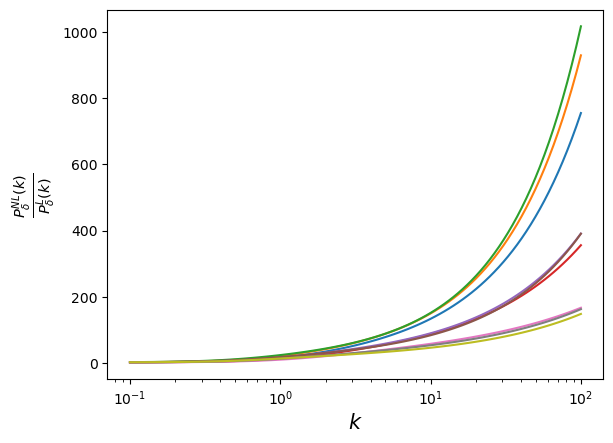

In [195]:
# TEST6: Plot power spectra linear/non-linear to compare to Huang et al 2020

k = np.logspace(np.log10(0.1),np.log10(100),num=100)
for i in range(len(cosmo)):
    plt.plot(k, ccl.power.nonlin_power(cosmo[i], k, 1)/ccl.power.linear_power(cosmo[i], k, 1) )

plt.xlabel(r'$k$', size = 15)
plt.ylabel(r'$\frac{P^{NL}_{\delta}(k) }{ P^{L}_{\delta}(k)}$', size = 15)

plt.xscale("log")

## Finding PCA components

PCA conventions in Python

A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12
\end{bmatrix}$ = [[a00, a01, a02], [a10, a11, a12]], with aij = A[i][j]

A[0] is first row, A[:][0] is first column

len(A) = number of rows, len(A[0]) = number of columns

AxB = np.matmul(A,B)

for B = $\begin{bmatrix}
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$, np.append(A,B, axis = 0) = A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12\\
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$ 

In [196]:
# Perform PCA (Choose n_components to keep)
pca = PCA()

Delta = np.transpose(B_data - M_data)
pca_array = pca.fit_transform(Delta)

In [197]:
print(len(pca_array))

990


In [198]:
U = np.transpose(pca_array)

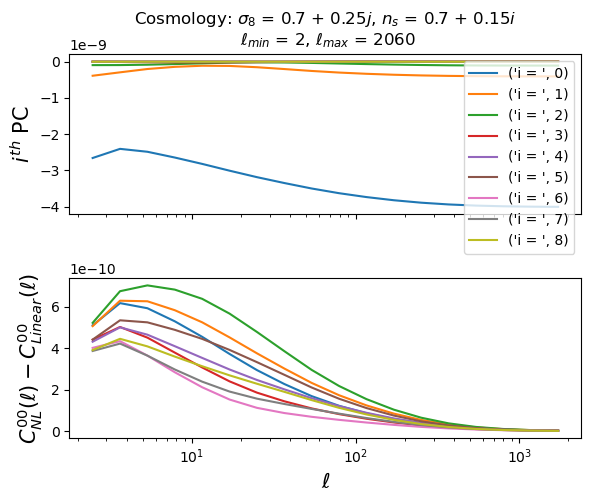

In [199]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)

for i in range(9):
    ax1.plot(ell[0:18], U[i][0: 18], label = ("i = ",i))
    
#plt.legend()
ax1.set_ylabel(r'$i^{th}$ PC', size = 15)
ax1.set_title("Cosmology: $\sigma_8$ = %1.1f + %1.2f$j$, $n_s$ = %1.1f + %1.2f$i$ \n $\ell_{min}$ = %i, $\ell_{max}$ = %i" \
          %(cosmo[0]["sigma8"], cosmo[1]["sigma8"] - cosmo[0]["sigma8"], cosmo[0]["n_s"], cosmo[3]["n_s"] - cosmo[0]["n_s"], ell_min, ell_max))
plt.xscale("log")

ax1.legend()

#plt.ylim(0,0.5)
for i in range(len(cosmo)):
    ax2.plot(ell[0:18],sub[i][0:18])
    
ax2.set_ylabel(r'$C^{00}_{NL}(\ell) - C^{00}_{Linear}(\ell)$', size = 15)
ax2.set_xlabel(r'$\ell$', size = 15)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

#plt.savefig('PCcompare.pdf')


## Code I don't use

In [ ]:
""" Defining useful functions to find C_ell """

# gives index of nearest value in array
def indx_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    
# note: z here is an array not a single value. returns array

def Wkappag(z, c, cosmo, binn_index):
    zmax = 6.                                                              # some reasonable max z over which to integrate
    a = 1/(1 + z)
    chiz = ccl.comoving_radial_distance(cosmo,a)                           # units of Mpc
    x_sample = np.linspace(z[0],zmax,int(1e3))                                # variable we integrate over
    px_sample = binning_redshiftdist(x_sample , 10)[0][binn_index]
    
    Wkg = np.zeros(len(z))     
    for i in range(len(z)):                                                # TODO is this a reasonable way of calculating this stuff?
        indx = indx_nearest(z[i], x_sample)
        x = x_sample[indx:]
        px = px_sample[indx:]
        ax = 1/(1 + x)
        chix = ccl.comoving_radial_distance(cosmo,ax)
        dchidx = c/(cosmo['H0']*ccl.h_over_h0(cosmo,ax))
        integrand = px*chiz[i]*(chix - chiz[i])/(a[i]*chix)
        Wkg[i] = scipy.integrate.simps(integrand, x)*3*cosmo['Omega_m']*(cosmo['H0']**2)/(2*c**2)
    Wkg[len(z)-1] = 0.0                                                    # The last integral is over nothing. to avoid nan
    
    return Wkg

# function that finds C_ell(ell) for a given z distribution.
# TODO: redshift normalization?

def findC_ell(cosmo, cosmoMCMC, c, ell, z, binn_index1, binn_index2):
                                                                          # find useful functs of z
    a = 1/(1 + z)
    chiz = ccl.comoving_radial_distance(cosmo,a)
    Wkg1 = Wkappag(z, c, cosmo, binn_index1)                                    # find tomographic lens efficiency
    Wkg2 = Wkappag(z, c, cosmo, binn_index2)                                    # find tomographic lens efficiency
                                                                          # find matter power spectrum
    MPS_MCMC = np.zeros((len(z),len(ell)))
    for i in range(len(z)):                                               # MatterPowerSpec_lz[i] is for ith z
        MatterPowerSpec_lz = ccl.power.nonlin_power(cosmo, (ell + 0.5)/chiz[i] , a[i])
        Linear_MPS = ccl.power.linear_power(cosmo, (ell + 0.5)/chiz[i] , a[i])
        MPS_MCMC[i] = (MatterPowerSpec_lz / Linear_MPS) * ccl.power.linear_power(cosmoMCMC, (ell + 0.5)/chiz[i] , a[i])
    
    MPS_MCMC = np.transpose(MPS_MCMC)
    C_ell = np.zeros(len(ell))
    
    for i in range(len(ell)):
        integrand = (Wkg1*Wkg2)*MPS_MCMC[i]/(chiz**2)
        C_ell[i] = scipy.integrate.simps(integrand, chiz, axis = 0)
    return C_ell